<a href="https://colab.research.google.com/github/2019mohamed/Enzyme-classification/blob/master/KernalTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install grakel

     |████████████████████████████████| 1.6MB 3.8MB/s 
     |████████████████████████████████| 163kB 12.1MB/s 


In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


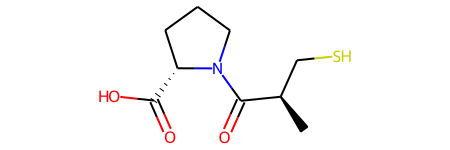

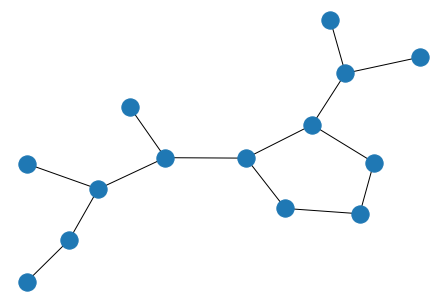

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import networkx as nx
import matplotlib.pyplot as plt

#"N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O"
#smile = 'COc(c1)cccc1C#N'
smile = 'O=C(O)[C@H]1N(C(=O)[C@H](C)CS)CCC1'
mol = Chem.MolFromSmiles(smile)


def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

g = mol_to_nx(mol)
nx.draw_kamada_kawai(g)

mol



In [ ]:
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from grakel.utils import graph_from_networkx
from grakel.datasets import fetch_dataset, get_dataset_info
from grakel.kernels import ShortestPath, WeisfeilerLehman, LovaszTheta
import pickle

MUTAG = fetch_dataset("PROTEINS", verbose=False)
G, y = MUTAG.data, MUTAG.target

G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.3, random_state=42)
gk = WeisfeilerLehman(normalize=True)
#filename = 'GraphKernalModel.sav'
K_train = gk.fit_transform(G_train)
#K_test = gk.fit_transform(G_test)

clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
#clf.fit(K_test, y_test)

'''
pickle.dump(clf, open(filename, 'wb'))
'''
#g = nx.generators.fast_gnp_random_graph(48,0.7)
nx.set_node_attributes(g, {i : '0' for i in list(g)}, 'label')
G_nx = [g]
G = graph_from_networkx(G_nx , node_labels_tag= 'label')
K_test = gk.transform(G)
#loaded_model = pickle.load(open(filename, 'rb'))
y_pred = clf.predict(K_test)
print(list(y_pred))
#acc = accuracy_score(y_test, y_pred)
#print("Accuracy:", str(round(acc*100, 2)) + "%")




[2]
